# Interação e Concorrência
## Trabalho Prático - Grupo 13


Grupo:
- André Morandi A86912
- Ivo Lima A90214


In [114]:
# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, transpile

# import visualization tools
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_hinton

import matplotlib.pyplot as plt
%matplotlib inline

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

Sabendo que o número do nosso grupo é $N$ = $13$

Temos de de usar um $\textit{quantum algorithm}$ para encontrar $s$ numa lista não ordenada, tal que

$$ s = N \space mod \space 8 $$

In [115]:
N = 13
s = N % 8
s

5

Passando o valor de $s$ para binário, ficamos com:

In [116]:
w = bin(s)[2:]
w # winner

'101'

Portanto, como $5$ em binário é $101$, iremos precisar de preparar um circuito quântico de 3 qubits

In [117]:
x = 3
print('Número de qubits: ', x)

Número de qubits:  3


In [118]:
qr_x      = QuantumRegister(x, 'x')
cr        = ClassicalRegister(x, 'cr')
qc_Grover = QuantumCircuit(qr_x,cr) # circuito quântico

Portanto, iremos inicializar o estado $s$. Para tal criamos a seguinte função:

In [119]:
def init(qc_Grover):
    qc_Grover.h(0)
    qc_Grover.h(1)
    qc_Grover.h(2)

### Implementação do Oracle

Para computar um $\textbf{quantum algorithm}$ baseado em um determinada função, podemos implementar uma espécie de $\textit{black box}$ da função. Passamos um $input$ $x$ e recebemos um $output$ $f(x)$.


Para resolver os problemas, podemos definir o oráculo da seguinte forma: marcaremos nossa solução (ou soluções) com uma fase negativa ($-1$). Desta forma, podemos usar o $\textbf{Grover's algorithm}$ para resolver.

$$ U_w \lvert x \rangle \Rightarrow x \neq w \rightarrow \lvert x \rangle $$
$$ U_w \lvert x \rangle \Rightarrow x = w \rightarrow -\lvert x \rangle $$ 

Tomando o valor $w$ como sendo $101$ resultará na seguinte matriz:

$$ U_w =  \begin{bmatrix}1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\    0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & −1 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\ \end{bmatrix}$$

In [120]:
def phase_oracle(qc_Grover, qr_x):
    qc_Grover.x(qr_x[0])
    qc_Grover.ccx(qr_x[0], qr_x[1], qr_x[2])
    qc_Grover.x(qr_x[2])

---------------------------------------------------------------------------------
De acordo com o que foi nos explicado durante as aulas da UC, a superposição colapsaria, sendo a probabilidade de cada uma das bases $\frac{1}{N} = \frac{1}{2^n}$ e o nossas chances de encontrar o valor $w$, $\textit{à priori}$, seria de $1$ em $2^n$.

O computador quântico utiliza a amplificação de amplitude para que possa aumentar a probabilidade. Este processo amplifica a amplitude do $w$ enquanto diminiu a dos outros.

![title](grover_step1.jpg)


Aplica-se a reflexão do oráculo ao estado $s$. Esta transformação significa que a amplitude média à frente do estado de $w$ tornar-se-á negativa (foi diminuída). 

---> IMAGEM







---------------------------------------------------------------------------------

### Diffuser

Since the average amplitude has been lowered by the first reflection, this transformation boosts the negative amplitude of
|
w
⟩
  to roughly three times its original value, while it decreases the other amplitudes. We then go to step 2 to repeat the application. This procedure will be repeated several times to zero in on the winner.
  
 

In [121]:
def diffuser(qc_Grover,qr_x):
    # INCOMPLETO
    qc_Grover.h(qr_x[1])
    qc_Grover.h(qr_x[0])
    qc_Grover.h(qr_x[2])
    qc_Grover.x(qr_x[0])
    qc_Grover.ccx(qr_x[0], qr_x[1], qr_x[2])
    qc_Grover.h(qr_x[0])
    qc_Grover.h(qr_x[1])
    qc_Grover.x(qr_x[2])
    qc_Grover.h(qr_x[2])

### Implementação Completa em Qiskit

O $qc\_Grover$ vai inicializer o quantum circuit

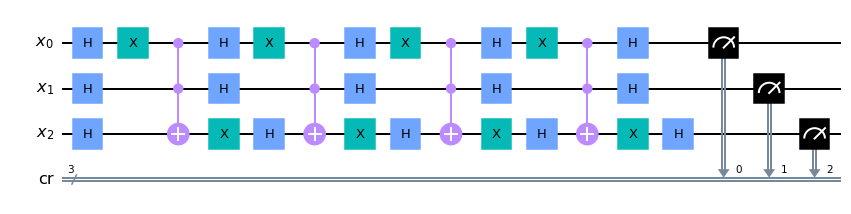

In [123]:
cr        = ClassicalRegister(x,'cr')
qc_Grover = QuantumCircuit(qr_x,cr)

init(qc_Grover)

for t in range(2):
    # phase oracle
    phase_oracle(qc_Grover, qr_x)
    # diffuser
    diffuser(qc_Grover,qr_x)
    
qc_Grover.measure(qr_x,cr)

qc_Grover.draw(output = 'mpl')

Agora iremos correr o circuito num simulador.

In [124]:
backend = Aer.get_backend("qasm_simulator")

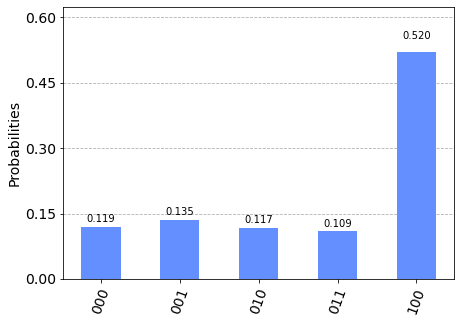

In [125]:
shots=1024
result = execute(qc_Grover, backend, shots=shots).result()
counts_sim = result.get_counts(qc_Grover)
plot_histogram(counts_sim)

In [127]:
qc_Grover.depth()

15

Agora iremos testar o circuito numa máquina quantum de verdade

### Correr num quantum computer

In [128]:
provider = IBMQ.load_account()
provider.backends()

ibmqfactory.load_account:WARNING:2021-06-01 19:24:36,281: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [129]:
# Backend overview
import qiskit.tools.jupyter

%qiskit_backend_overview

In [130]:
from qiskit.tools.monitor import backend_overview, backend_monitor

backend_overview()

ibmq_manila                  ibmq_quito                  ibmq_belem
-----------                  ----------                  ----------
Num. Qubits:  5              Num. Qubits:  5             Num. Qubits:  5
Pending Jobs: 11             Pending Jobs: 0             Pending Jobs: 0
Least busy:   False          Least busy:   True          Least busy:   False
Operational:  True           Operational:  True          Operational:  True
Avg. T1:      155.8          Avg. T1:      88.9          Avg. T1:      83.6
Avg. T2:      64.4           Avg. T2:      80.4          Avg. T2:      76.4



ibmq_lima                    ibmq_santiago                ibmq_athens
---------                    -------------                -----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 37             Pending Jobs: 8              Pending Jobs: 1
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operational:  T

Escolhemos a '$\textbf{ibmq_santiago}$' devido ao Avgerage $T1$ ($\textit{relaxation time}$) e $T2$ ($\textit{coherence time}$) e também por causa da quantidade de qubits superior ou igual a 3.

In [134]:
backend_device = provider.get_backend('ibmq_santiago')
print("Running on: ", backend_device)

Running on:  ibmq_santiago


In [135]:
# See backend information
backend_device

<IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>

In [136]:
backend_monitor(backend_device)

ibmq_santiago
Configuration
-------------
    n_qubits: 5
    operational: True
    status_msg: active
    pending_jobs: 5
    backend_version: 1.3.22
    basis_gates: ['id', 'rz', 'sx', 'x', 'cx', 'reset']
    local: False
    simulator: False
    credits_required: True
    qubit_lo_range: [[4.333430263840619e+18, 5.33343026384062e+18], [4.1236091586520883e+18, 5.123609158652088e+18], [4.3205331213928325e+18, 5.320533121392833e+18], [4.2423098739543076e+18, 5.242309873954307e+18], [4.316328092193655e+18, 5.316328092193655e+18]]
    max_shots: 8192
    meas_levels: [1, 2]
    multi_meas_enabled: True
    supported_instructions: ['play', 'shiftf', 'reset', 'cx', 'delay', 'u3', 'measure', 'u2', 'x', 'sx', 'id', 'setf', 'rz', 'u1', 'acquire']
    channels: {'acquire0': {'operates': {'qubits': [0]}, 'purpose': 'acquire', 'type': 'acquire'}, 'acquire1': {'operates': {'qubits': [1]}, 'purpose': 'acquire', 'type': 'acquire'}, 'acquire2': {'operates': {'qubits': [2]}, 'purpose': 'acquire', 'ty

In [137]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [138]:
job_r = execute(qc_Grover, backend_device, shots=shots)

jobID_r = job_r.job_id()

print('JOB ID: {}'.format(jobID_r))

JOB ID: 60b67da89461fe496f0db7f0


In [139]:
job_get=backend_device.retrieve_job("60b67da89461fe496f0db7f0")

result_r = job_get.result()
counts_run = result_r.get_counts(qc_Grover)

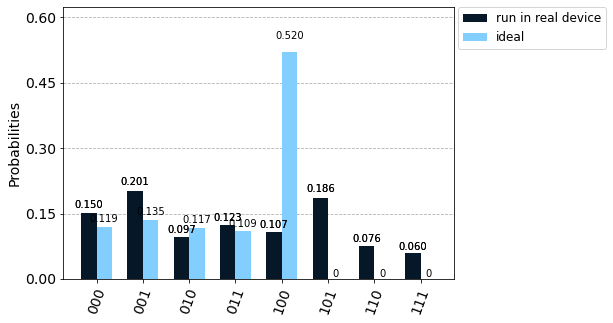

In [140]:
plot_histogram([counts_run, counts_sim ], legend=[ 'run in real device', 'ideal'], color=['#061727','#82cfff'])

Desta forma, concluímos que há uma maior chance de medir |101⟩. Os outros resultados ocorrem devido aos erros da computação quântica.

### IGNIS

É uma calibração usada para diminuir os erros de medição.

### Calibration Matrix

Como temos 3 qubits, precisamos de um circuito de calibração da ordem $2^3 = 8$

In [142]:
# Generate the calibration circuits
qr = QuantumRegister(x)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr, circlabel='mcal')

In [143]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

Num caso idealista onde não existiria barulho/erro, a matriz de calibração seria uma matriz identidade $8x8$. Mas, uma vez que estamos a aplicar num dispositvo quântico real, haverá sempre algum barulho/erro.

In [144]:
job_ignis = execute(meas_calibs, backend=backend_device, shots=shots)

jobID_run_ignis = job_ignis.job_id()

print('JOB ID: {}'.format(jobID_run_ignis))

JOB ID: 60b67e815e6b3071a7cfcd8b


In [145]:
job_get=backend_device.retrieve_job("60b67e815e6b3071a7cfcd8b")

cal_results = job_get.result()

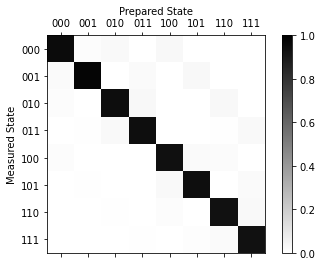

In [146]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

# Plot the calibration matrix
meas_fitter.plot_calibration()

### Análise de Resultados

A $\textit{ average assignment fidelity }$ é o traço da diagonal da matriz anterior. 

In [148]:
# Qual a medida de fidelidade?
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

Average Measurement Fidelity: 0.943726


### Calibração

In [151]:
# Filtro
meas_filter = meas_fitter.filter

# Resultados (mitigation)
mitigated_results = meas_filter.apply(result_r)
mitigated_counts = mitigated_results.get_counts()

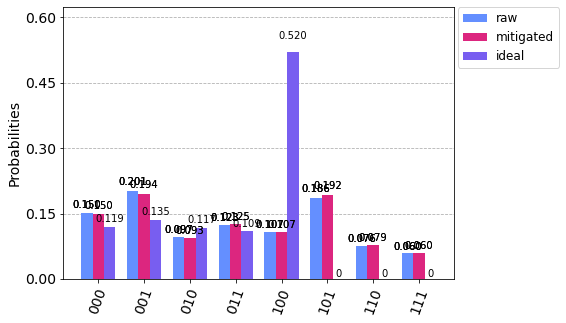

In [152]:
plot_histogram([counts_run, mitigated_counts, counts_sim], legend=['raw', 'mitigated', 'ideal'])